# all scores scikit-learn - overfitting example :) 

## In this notebook:

* single input dataframe 
* using feature set 1
* model: random forest and SVM
* only training/test split, no epochs 
* aucuracy assessement of RF:  0.82
* aucuracy assessement of SVM:  0.76 (rbf)
* feature importance for RF (mostly just amino acid position)

In [1]:
import torch
import pandas as pd
import numpy as np

# using sklearn goodies
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split


## pull in pickled dataframe:
df = pd.read_pickle("./pickled_dfset1_chr234.pkl")



print("shape before", df.shape)
df = df.replace({'.': 0})  ## FIXME: atm replace with nan and drop: later find a way to impute, maybe 0 but not sure
#print("SUM", pd.isnull(df).sum())  ## Use this to see how many elements have nan 
df = df.dropna()
print("shape after dropping all data with score = '.'", df.shape)
#print(df.head())

## still contains some mixed labels, see them by: df[~df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]

## Map labels to 1/0 and remove Unkn
clinvar_labels={
    'Pathogenic': 1,
    'Likely_pathogenic': 1,
    'Pathogenic/Likely_pathogenic': 1,
    'Benign/Likely_benign': 0,
    'Likely_benign': 0,
    'Benign': 0
}

#df.head()
#df = df[df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]  # best to drop everything that isn't in the dict
#df['Problematic'] = df['clinvar_clnsig'].map(clinvar_labels)

#df= df.drop(columns=['clinvar_clnsig'])#, 'clinvar_id'])  #tbh, I don't know why I kept them. consider adding to index

df = df.replace({'-': 0}) 
print("shape after dropping Unk", df.shape)
#df.head()

### pickle to reuse dataframe:
#df.to_pickle("./pickled_df/all_scores_chr18,20.pkl")


shape before (11724, 9)
shape after dropping all data with score = '.' (11724, 9)
shape after dropping Unk (11724, 9)


In [2]:
## Split into train/test
data_copy = df.copy()
df_train = data_copy.sample(frac=0.75, random_state=1)
df_test = data_copy.drop(df_train.index)

print ('Training data subset\n')
print (df_train.head(3))  # head default n=5, first 3 is enough
print ('\nTest data subset\n')
print (df_test.head(3))


## Get label:
train_labels = df_train.pop('Problematic')  # replace with clinvar when column is available
test_labels = df_test.pop('Problematic')

Training data subset

                       aapos TSL codonpos HUVEC_fitCons_score  \
chr pos       ref alt                                           
3   38562432  G   A     1316   1        1            0.668105   
2   178597618 C   T    17514   5        2            0.620846   
    47783349  G   A       39   1        2            0.241949   

                           ExAC_cnv.score          GDI LoFtool_score  \
chr pos       ref alt                                                  
3   38562432  G   A     0.409458335109176   1128.17048      4.13E-04   
2   178597618 C   T                     0  74772.86558      9.71E-01   
    47783349  G   A    -0.157953293495921   1431.22959      2.12E-02   

                       SORVA_LOF_MAF0.005_HetOrHom  Problematic  
chr pos       ref alt                                            
3   38562432  G   A                       0.000799            1  
2   178597618 C   T                       0.017173            0  
    47783349  G   A        

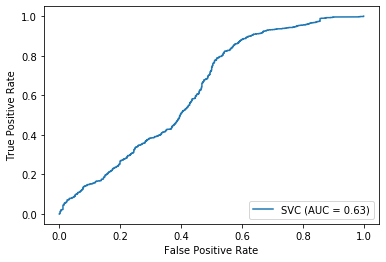

y true [0 0 0 ... 1 0 1]
y predicted [1 1 1 ... 1 1 1]
Confusion matrix: 
 [[ 195  552]
 [ 132 2015]]
Accuracy: 0.7636489288182446
Recall TP/(TP+FN): [0.26104418 0.93851886]
Precision TP/(TP+FP): [0.59633028 0.78496299]
F1: [0.36312849 0.8549003 ]


In [3]:
## Try a binary support vector machine:

classifier1 = SVC(kernel='rbf', gamma='scale',random_state=42) # default for kernel and gamma. AUC = 0.94
#classifier2 = SVC(kernel='linear', gamma=10 ,random_state=42) # 0.94
#classifier3 = SVC(kernel='sigmoid', gamma=10 ,random_state=42) # 0.82

classifier1.fit(df_train, train_labels)
svc_disp = plot_roc_curve(classifier1, df_test, test_labels)
plt.show()


### Run some stats to see if the model is doing well. 
### Note: for chr20, there are 696 exampels that pass, meaning 25% used for testing gives low numbers, see cm
y_true = test_labels.to_numpy()
y_pred = classifier1.predict(df_test)


print("y true", y_true) ## These are both numpy arrays now, why are the metrics returning arrays rather than single f
print("y predicted", y_pred)

## see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall_score

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion matrix: \n", confusion_matrix(y_true, y_pred))

# Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred))

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred, average=None)
print("Recall TP/(TP+FN):", recall)

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred, average=None)
print("Precision TP/(TP+FP):",precision)


# F1 score
F1 = 2 * (precision * recall) / (precision + recall)
print("F1:", F1)

In [4]:
#type(y_true.to_numpy())  # pandas.core.series.Series
#type(y_pred) # numpy.ndarray

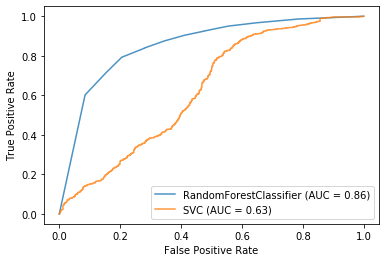

Accuracy: 0.8182446440912232
Confusion matrix: 
 [[ 489  258]
 [ 268 1879]]
Feature ranking:
1. feature 0 (0.421214)
aapos
2. feature 6 (0.127525)
LoFtool_score
3. feature 3 (0.119264)
HUVEC_fitCons_score
4. feature 5 (0.106588)
GDI
5. feature 4 (0.079309)
ExAC_cnv.score
6. feature 2 (0.066781)
codonpos
7. feature 7 (0.047675)
SORVA_LOF_MAF0.005_HetOrHom
8. feature 1 (0.031644)
TSL


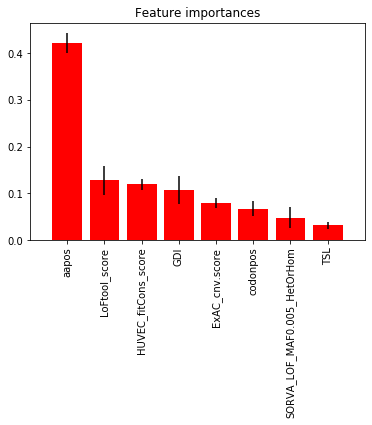

In [5]:
# Try a random forest:

forest = RandomForestClassifier(n_estimators=10, random_state=42)
forest.fit(df_train, train_labels)
ax = plt.gca()
rfc_disp = plot_roc_curve(forest, df_test, test_labels, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

## metrics:
y_true = test_labels.to_numpy()
y_pred = forest.predict(df_test)
print("Accuracy:", accuracy_score(y_true, y_pred))
# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion matrix: \n", confusion_matrix(y_true, y_pred))


## Get at and plot the feature importance (tutorial: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
feature_labels = list(df_train) # columns names
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(df_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print(feature_labels[indices[f]])

    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_train.shape[1]), labels=df_train.columns[indices], rotation=90)
plt.xlim([-1, df_train.shape[1]])
plt.show()